In [10]:
#!/usr/bin/python
# -*- encoding: utf-8 -*-
'''
@File    :   可视化目标和预测的ss曲线.ipynb
@Time    :   2024/05/25 20:57:03
@Author  :   Hengda.Gao
@Contact :   ghd@nudt.edu.com
@Desc    :   1. 计算预测应力应变曲线
             2. 加载目标应力应变曲线
             3. 矫正：-bias
             4. 可视化连通的目标和预测曲线误差
              
'''
from pathlib import Path
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
from PIL import Image
import numpy as np
import pandas as pd
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

CHANNELS_TO_MODE = {
    1 : 'L',
    3 : 'RGB',
    4 : 'RGBA'
}

def seek_all_images(img, channels = 3):
    assert channels in CHANNELS_TO_MODE, f'channels {channels} invalid'
    mode = CHANNELS_TO_MODE[channels]
    i = 0
    while True:
        try:
            img.seek(i)
            yield img.convert(mode)
        except EOFError:
            break
        i += 1

# gif -> (channels, frame, height, width) tensor
def gif_to_tensor(path, channels = 1, transform = T.ToTensor()):
    img = Image.open(path)
    tensors = tuple(map(transform, seek_all_images(img, channels = channels)))
    return torch.stack(tensors, dim = 1)

def get_frames(path):
    video_tensor = gif_to_tensor(path).squeeze()
    sample_number = video_tensor.shape[-2]//128
    shape_number = video_tensor.shape[-1]//128
    # print(sample_number, shape_number)
    all_list = []
    for i in range(video_tensor.shape[0]):
        frame_list = []
        sample = np.split(video_tensor[i],sample_number , axis=0)
        for k in range(sample_number):   
            sample_list = [
            np.split(sample[k], shape_number, axis=1)[j][2:-2, 2:-2]
            for j in range(shape_number) 
            ]
            frame_list.append(sample_list)
        all_list.append(frame_list)
    all_list = np.array(all_list)
    return all_list

In [8]:
os.chdir('/home/hengda/VideoMetamaterials/')
from src.utils import plot_static, plot_dynamic 
os.chdir('/home/hengda/VideoMetamaterials//')
os.system('pwd')

/home/hengda/VideoMetamaterials


0

# 计算得到Fwd曲线

In [21]:
sample_dir = '/home/hengda/VideoMetamaterials/runs/debug-128/eval_target_w_5.0_2/step_200000/gifs'
if not sample_dir:
    raise ValueError('sample_dir is not defined')
output_dir = '/home/hengda/VideoMetamaterials/runs/debug-128/eval_target_w_5.0_2/step_200000/gifs-post'

In [12]:
s_22 = get_frames(f'{sample_dir}/prediction_channel_2.gif')
topo = get_frames(f'{sample_dir}/prediction_channel_3.gif')

# 加载min_max_values.csv
min_max = '/home/hengda/VideoMetamaterials/script/training-54569/min_max_values.csv'
d = pd.read_csv(min_max, index_col=0, header=None, names=['A','B'])
def unnorm(arr, min_val, max_val):
    return arr * (max_val - min_val) + min_val

# 反归一化
s_22.shape # (frames, samples, shapes, 128, 128)
s_22_unnorm = unnorm(s_22, d["B"].min_s_22, d["B"].max_s_22)
s_22_unnorm[topo[0,...][np.newaxis,:].repeat(11, 0) < 0.5] = 0   # 小于0.5的区域设为无材料区域

In [14]:
eval_points = np.linspace(0, 0.2, 11)
eval_points[0] = 0.01 * 0.2
eval_points

array([0.002, 0.02 , 0.04 , 0.06 , 0.08 , 0.1  , 0.12 , 0.14 , 0.16 ,
       0.18 , 0.2  ])

In [15]:
Fwd_s_22 = (  abs(s_22_unnorm.mean(-1).mean(-1)) / (1- eval_points)[:,np.newaxis, np.newaxis]    )
sample_index = 0
shape_index = 0
Fwd_s_22_0=Fwd_s_22[:,sample_index,shape_index]
Fwd_s_22_0

(11, 20, 5)

# 加载条件曲线

In [35]:
Target = np.genfromtxt('/home/hengda/VideoMetamaterials/data/target_responses.csv', delimiter=',') # 确定加载的正确
print(Target.shape)

(20, 11)


In [39]:
def compute_NRMSE(y_true, y_pred):
    return np.sqrt(np.sum(np.square(y_pred - y_true))/np.sum(np.square(y_true)))

def extrapolate(Fwd, eval_points):
    y2 = Fwd[1]
    y1 = Fwd[0]
    x1 = eval_points[0]
    x2 = eval_points[1]
    y = (y2-y1)/(x2-x1)*(0-x2) + y2
    return y

In [52]:
def plot(sample_index=0,shape_index=0):
    fig, ax=plt.subplots()
    plt.title(f'topo_{sample_index}_{shape_index} Stress-Strain Curve')
    plt.scatter(eval_points*100,Target[sample_index],label='Target',color='red',marker='o')  # 目标曲线
    
    
    
    plt.xlabel('Strain (%)')
    plt.ylabel('Stress (MPa)')
    
    bias = extrapolate(Fwd_s_22[:,sample_index,shape_index], eval_points)
    NRMSE_Fwd = round(compute_NRMSE(Target[sample_index,:],Fwd_s_22[:,sample_index,shape_index]-bias)*100,1)
    plt.scatter(eval_points*100,Fwd_s_22[:,sample_index,shape_index]-bias,label=f'Fwd eval({NRMSE_Fwd}%)',color='green',marker='^' )
    
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.legend(frameon=False)
    plt.savefig(f'{output_dir}/topo_{sample_index}_{shape_index}_curve.jpg',bbox_inches='tight', pad_inches=0, dpi=300)
    plt.show()


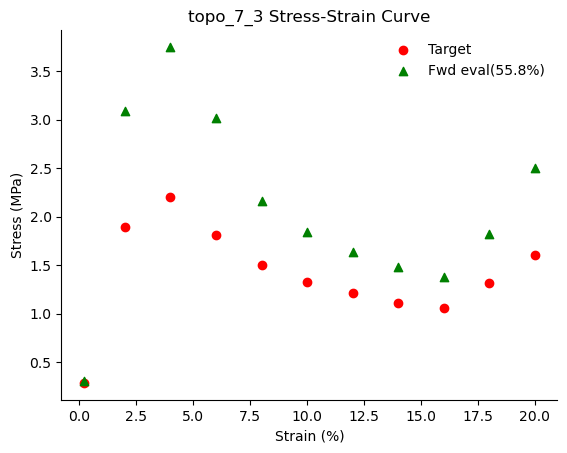

In [53]:
plot(7,3)

In [54]:
# 检测连通性，打印图片，以供仿真, 看是否需要改变尺寸
def check_connectivity(f_bar):
    import cv2
    binary_matrix = cv2.threshold(f_bar, 127, 155, cv2.THRESH_BINARY)[1]
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_matrix, connectivity=8)
    num_components = retval - 1  
    if num_components == 1: 
        return True
    else:
        print("*"*50)
        print(f'num_components:{num_components}')
        print("*"*50)
        return False

In [55]:
# 保存连通图片
from tqdm import tqdm
def save_connectivity():
    import cv2
    for i in tqdm(range(topo.shape[1])):
        for j in range(topo.shape[2]):
            topo_0 = np.uint8((topo[0,i,j] >  0.5))*255
            if check_connectivity(topo_0):
                plot(i,j)    
            else:
                print(f'topo_{i}_{j}不连通')

  0%|          | 0/20 [00:00<?, ?it/s]

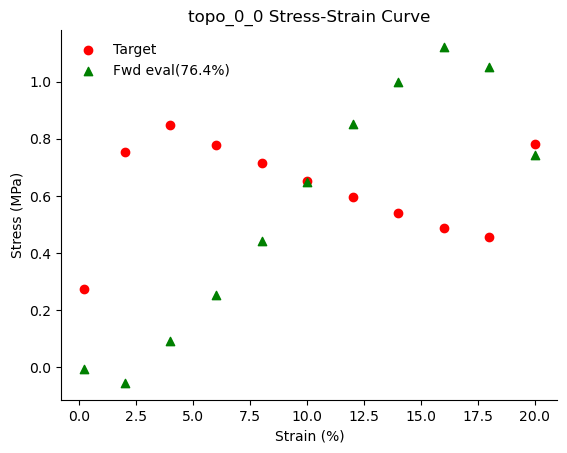

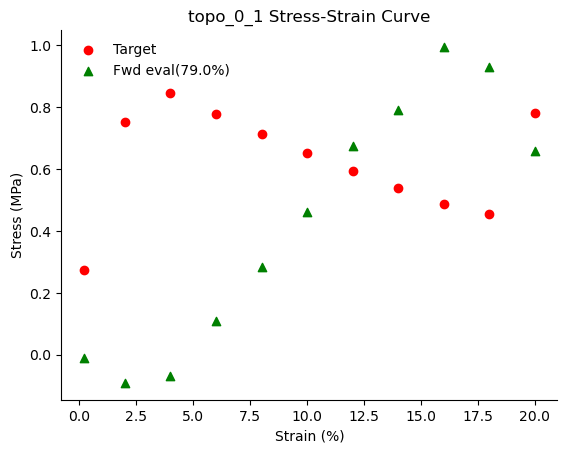

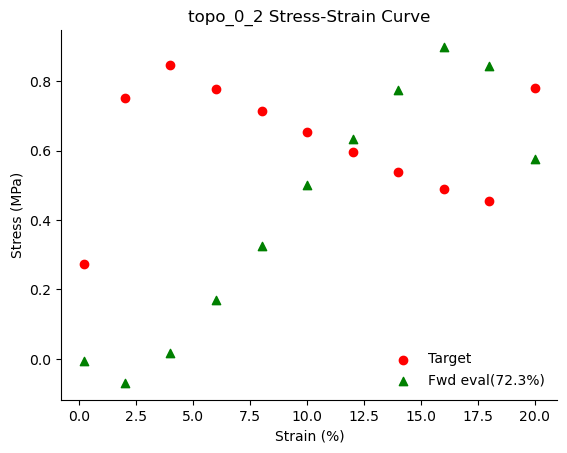

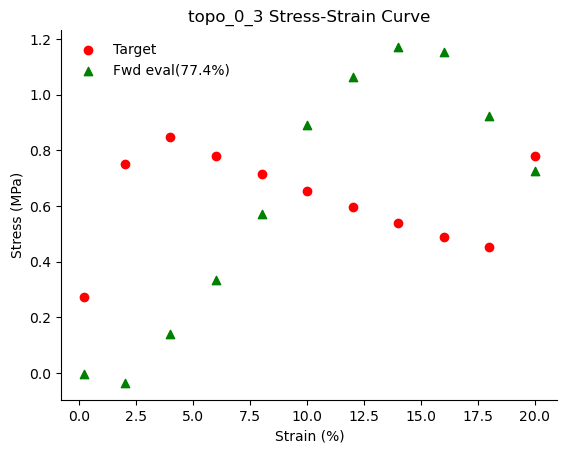

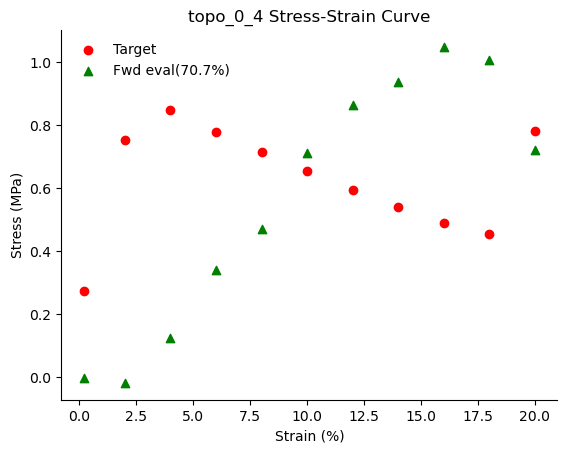

  5%|▌         | 1/20 [00:00<00:18,  1.03it/s]

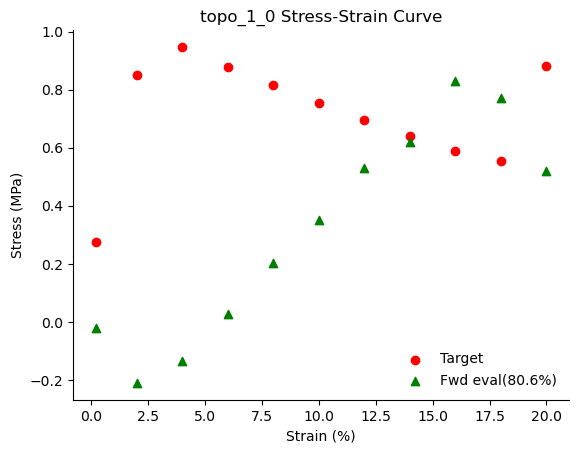

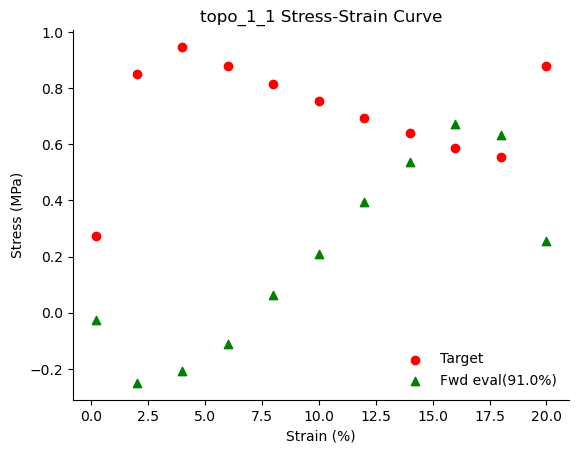

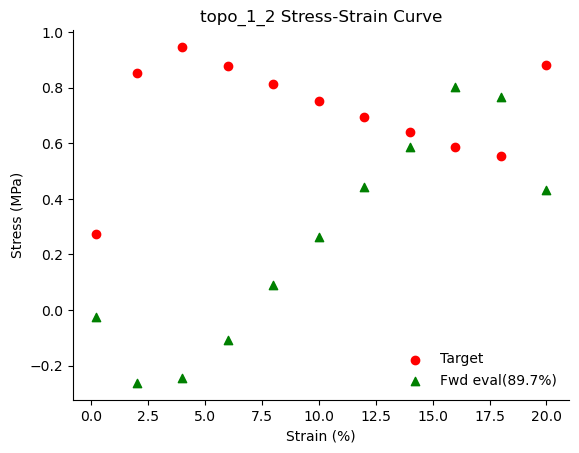

**************************************************
num_components:2
**************************************************
topo_1_3不连通


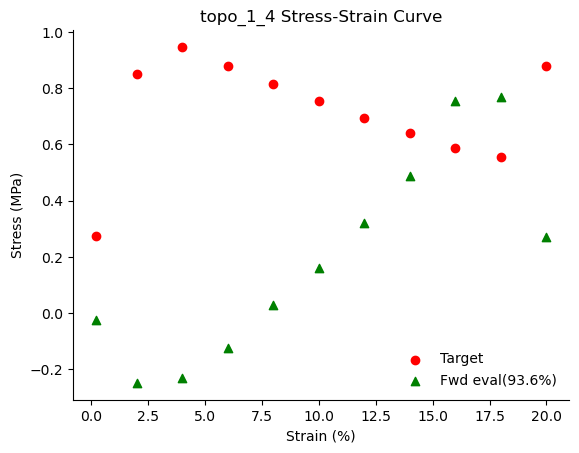

 10%|█         | 2/20 [00:01<00:15,  1.17it/s]

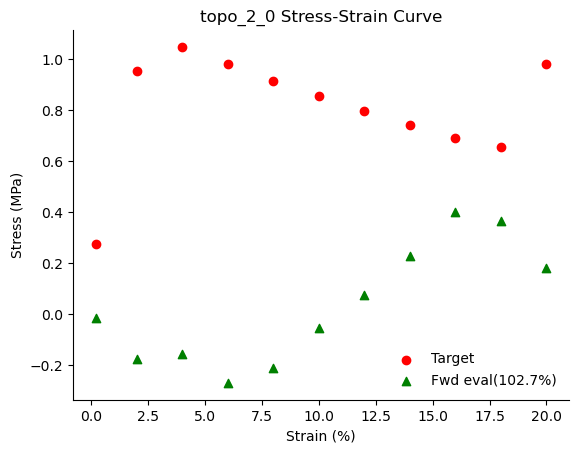

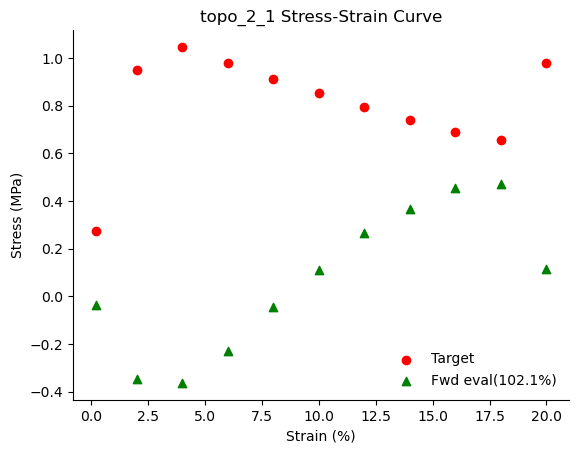

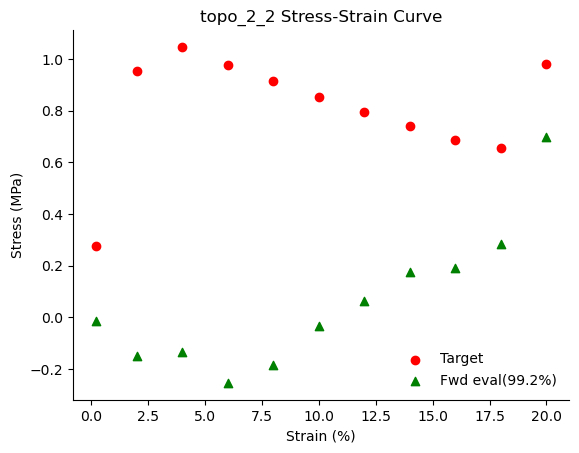

**************************************************
num_components:2
**************************************************
topo_2_3不连通


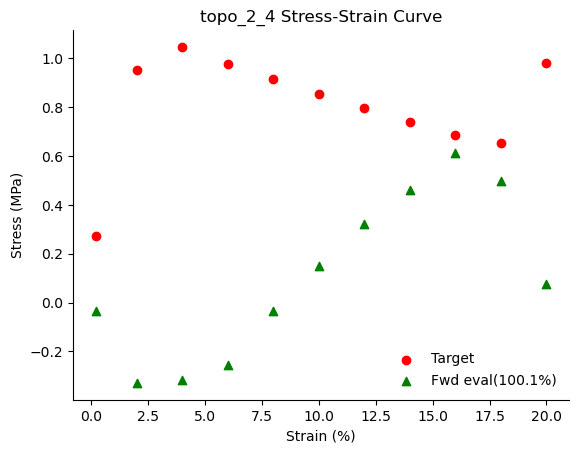

 15%|█▌        | 3/20 [00:02<00:14,  1.21it/s]

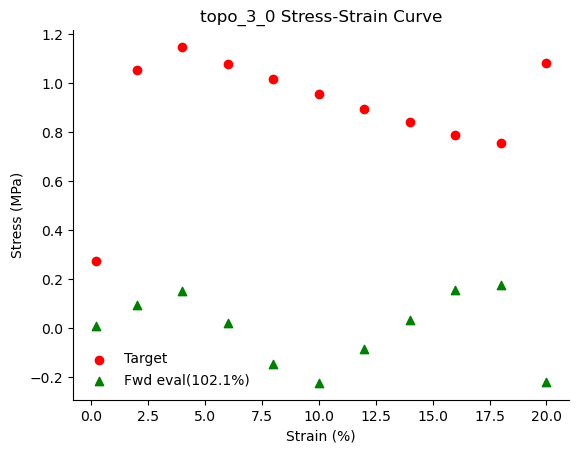

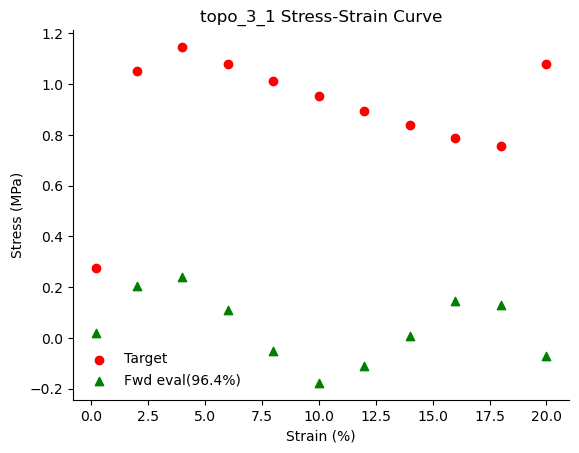

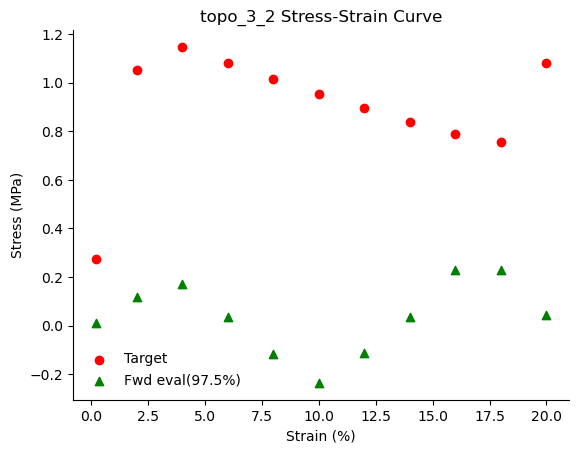

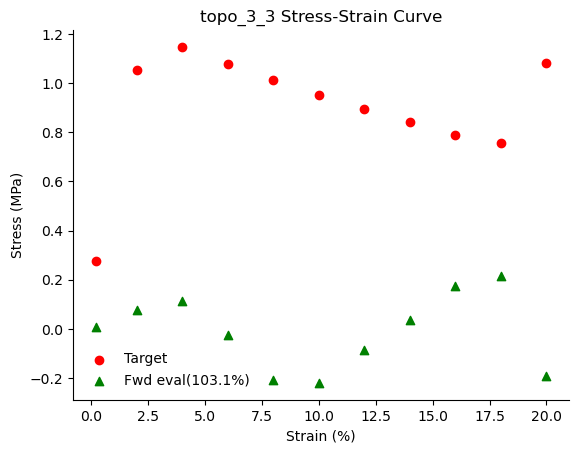

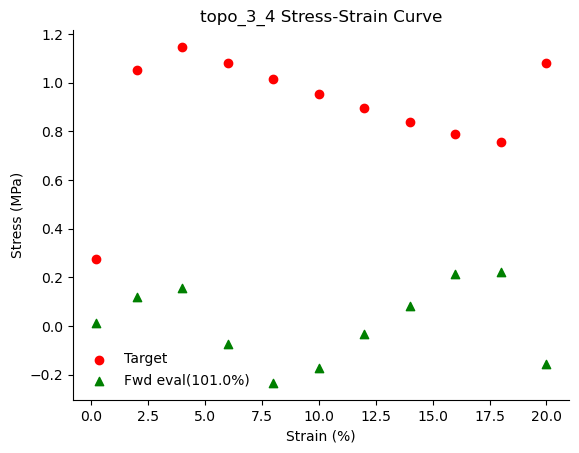

 20%|██        | 4/20 [00:03<00:14,  1.12it/s]

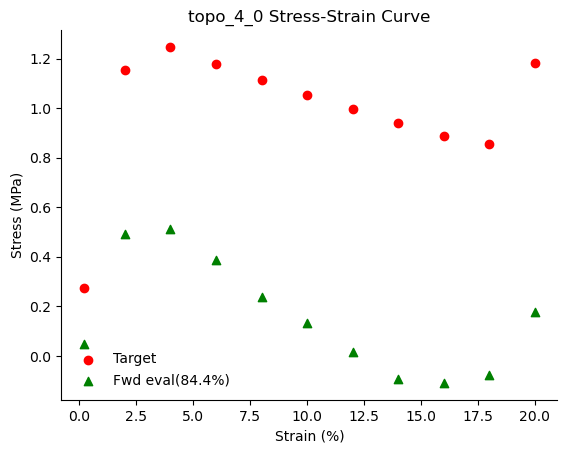

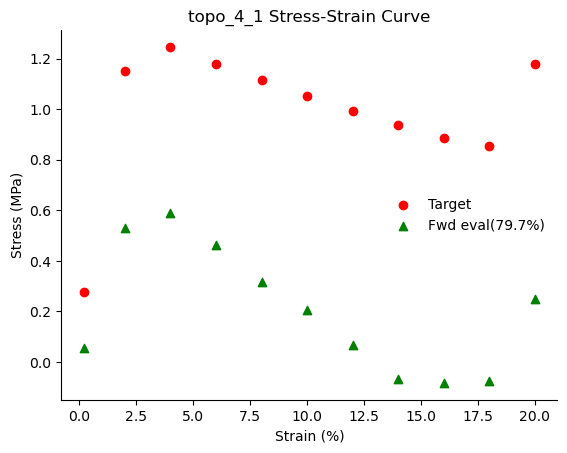

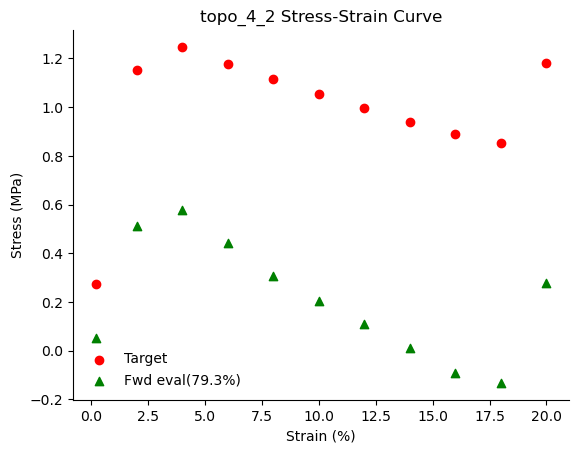

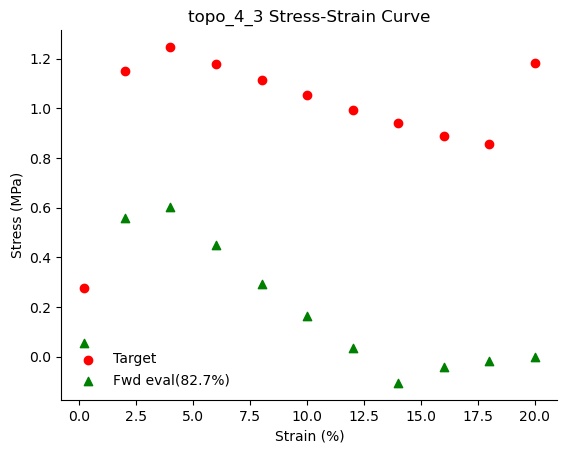

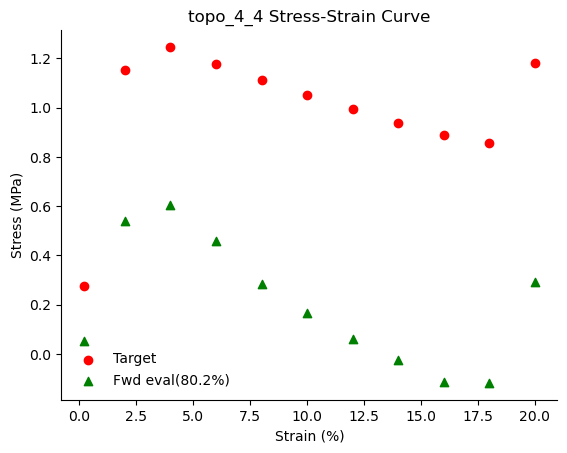

 25%|██▌       | 5/20 [00:04<00:13,  1.08it/s]

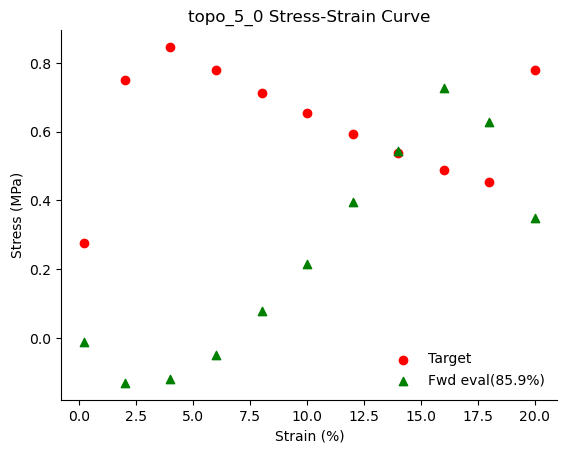

**************************************************
num_components:2
**************************************************
topo_5_1不连通


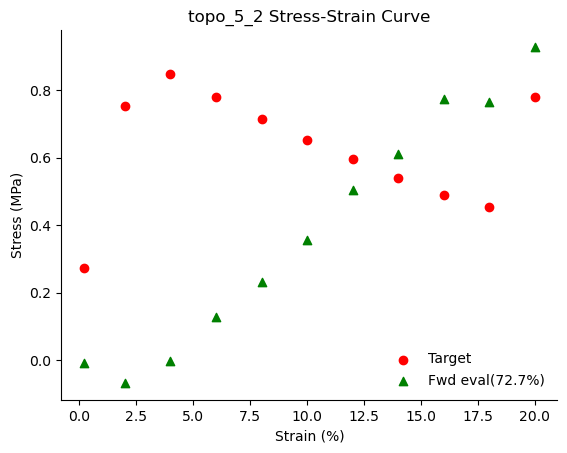

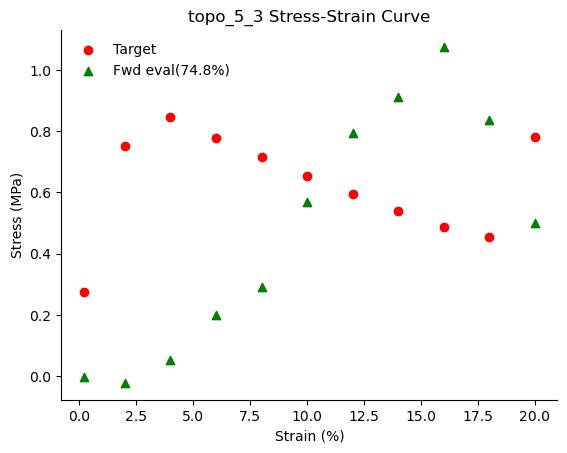

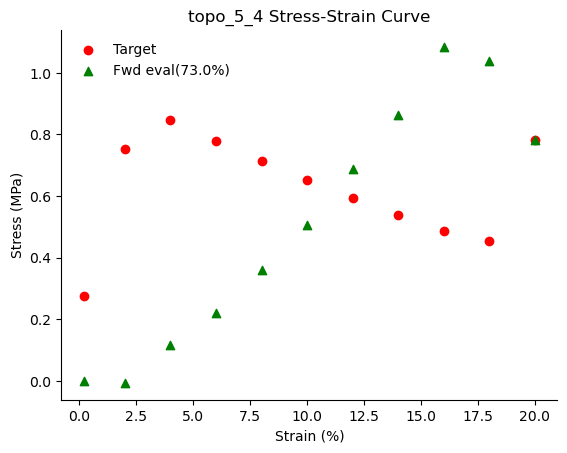

 30%|███       | 6/20 [00:05<00:13,  1.06it/s]

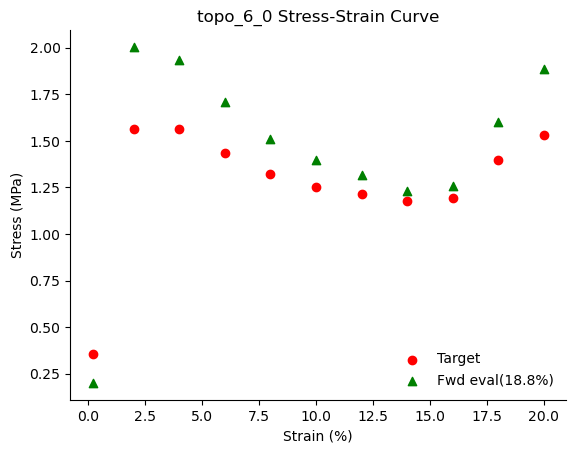

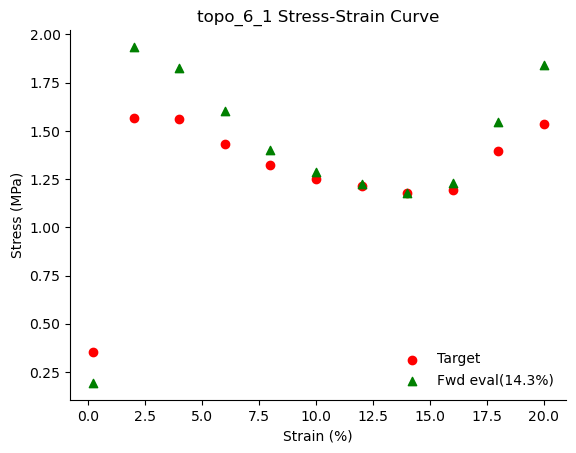

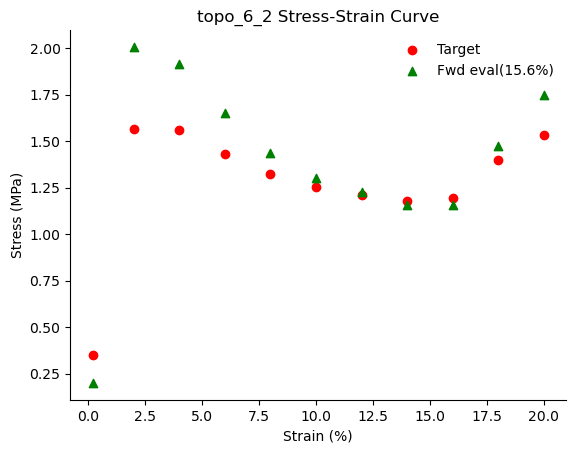

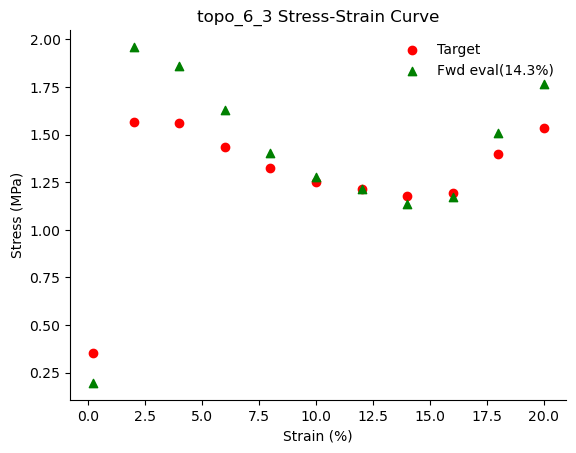

 35%|███▌      | 7/20 [00:06<00:11,  1.10it/s]

**************************************************
num_components:2
**************************************************
topo_6_4不连通


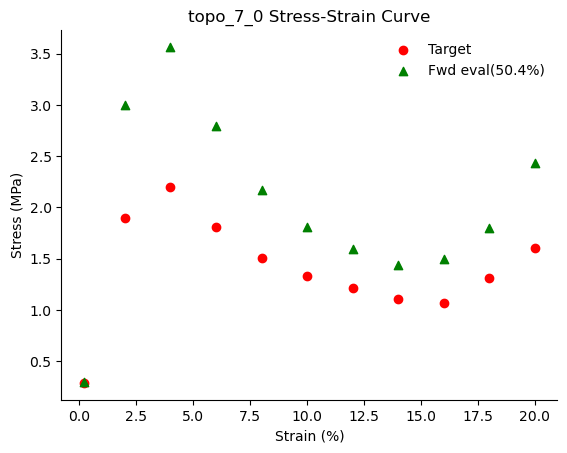

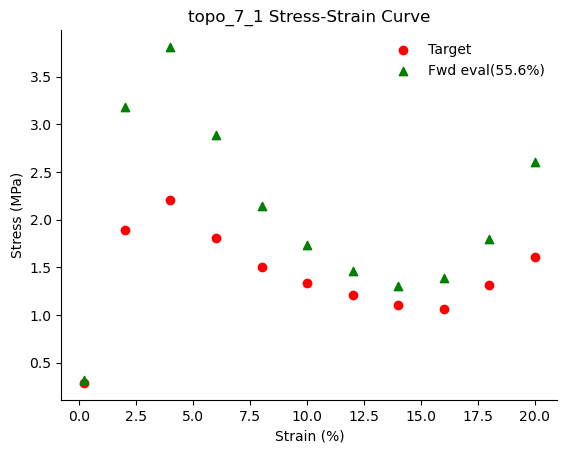

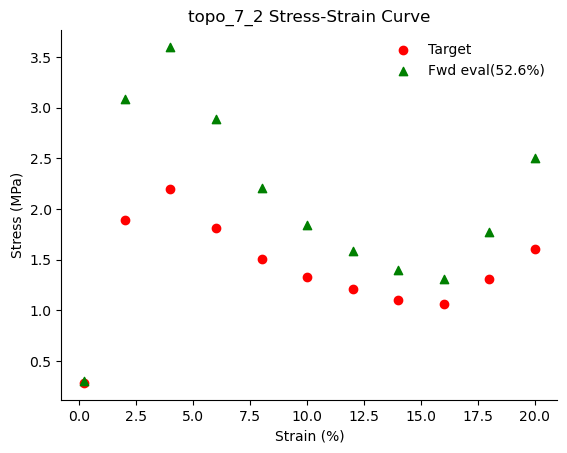

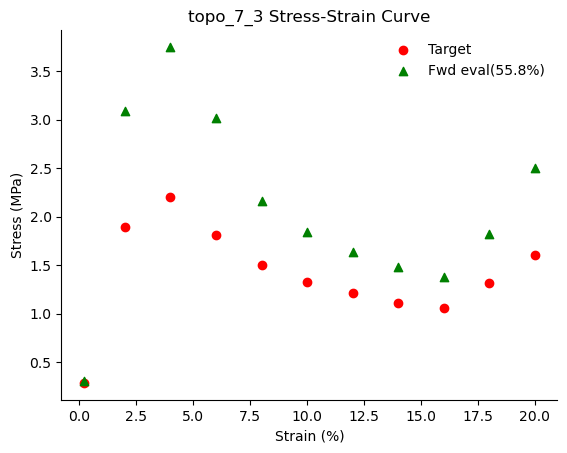

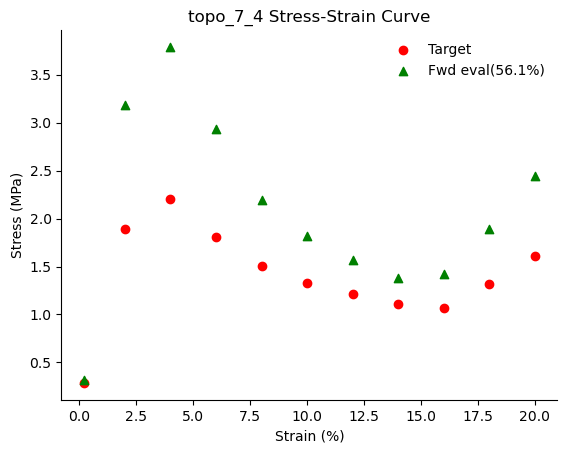

 40%|████      | 8/20 [00:07<00:11,  1.07it/s]

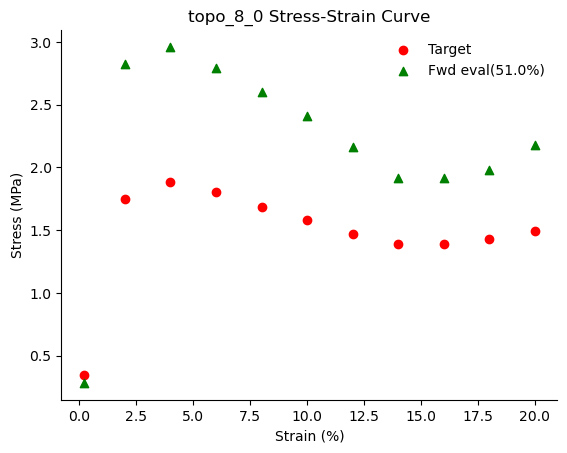

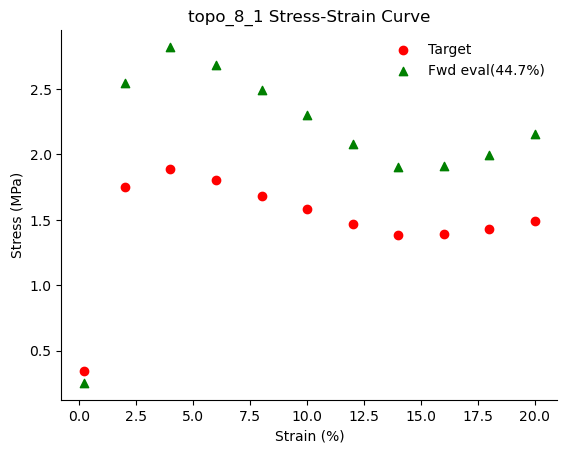

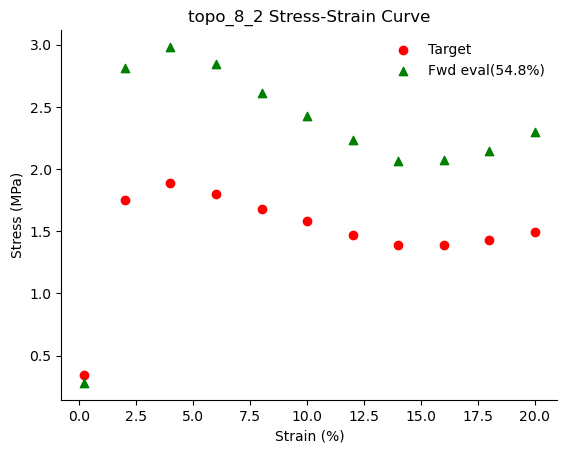

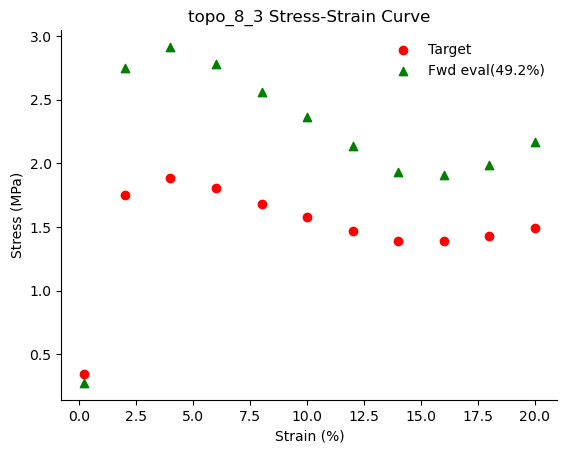

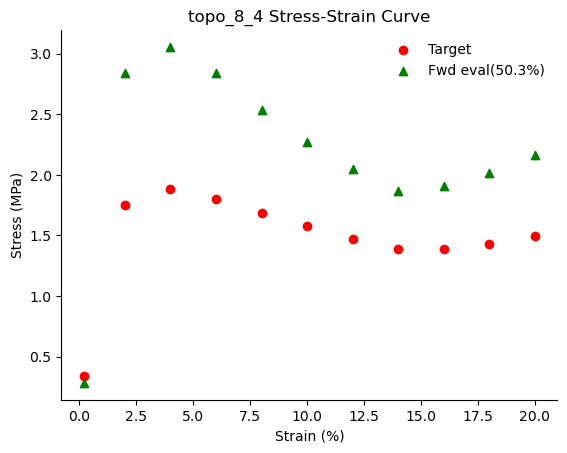

 45%|████▌     | 9/20 [00:08<00:10,  1.07it/s]

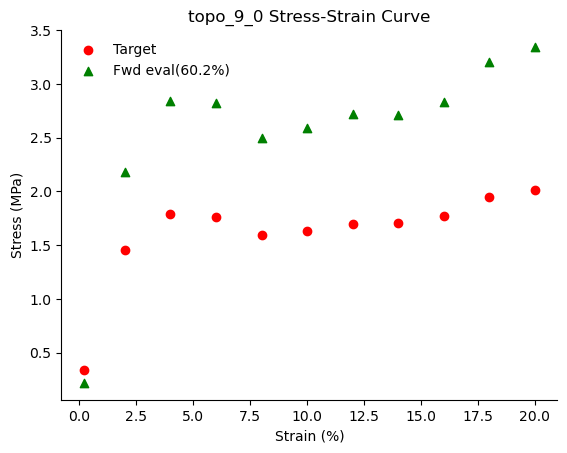

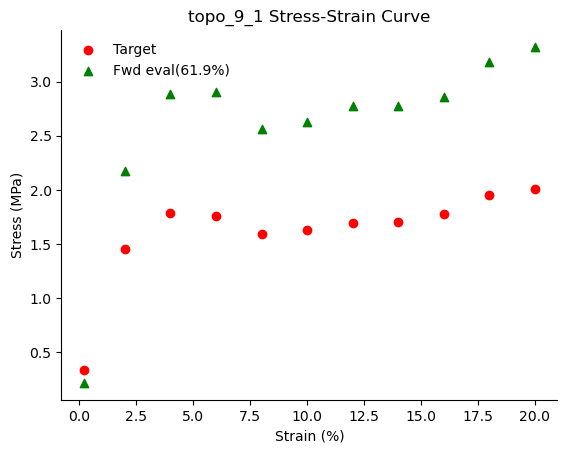

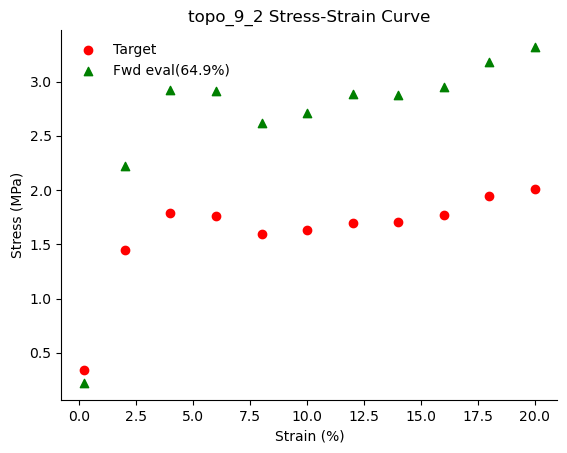

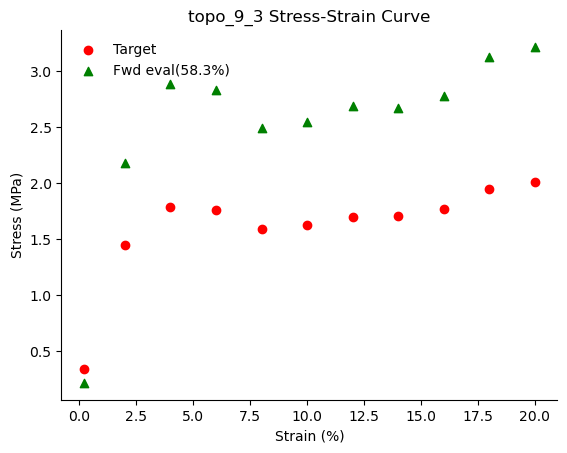

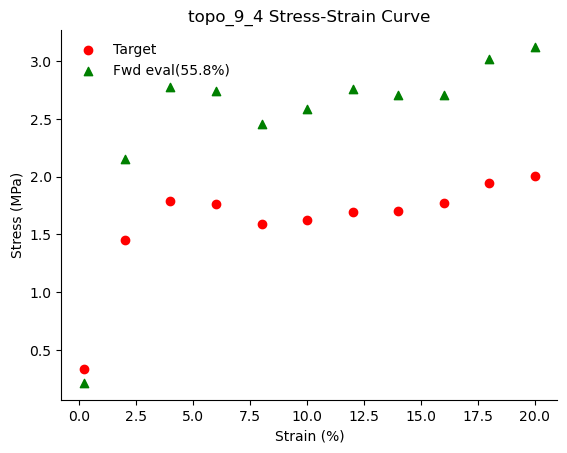

 50%|█████     | 10/20 [00:09<00:09,  1.06it/s]

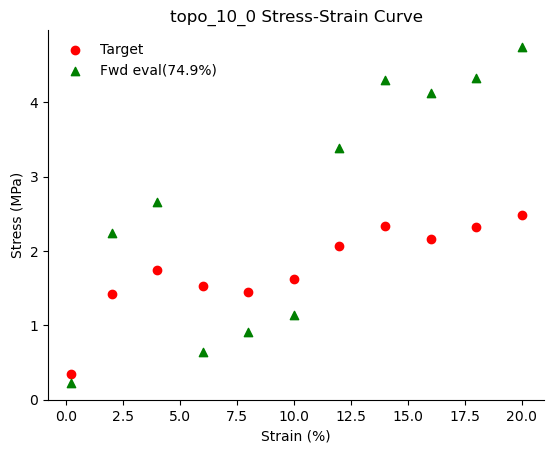

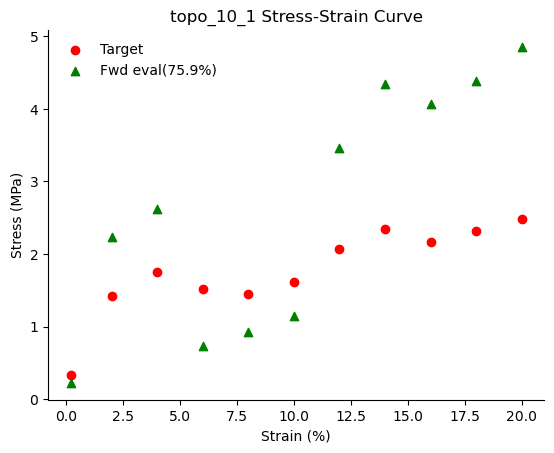

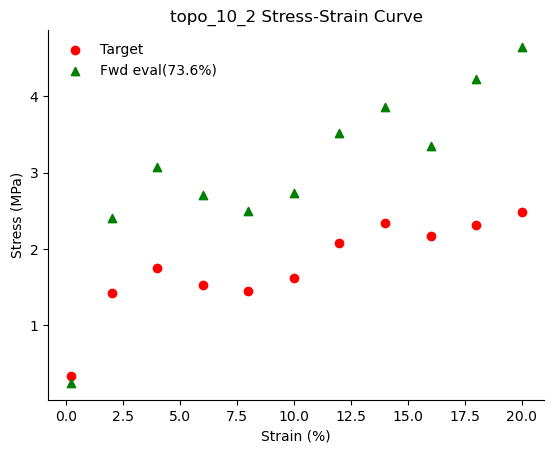

**************************************************
num_components:2
**************************************************
topo_10_3不连通


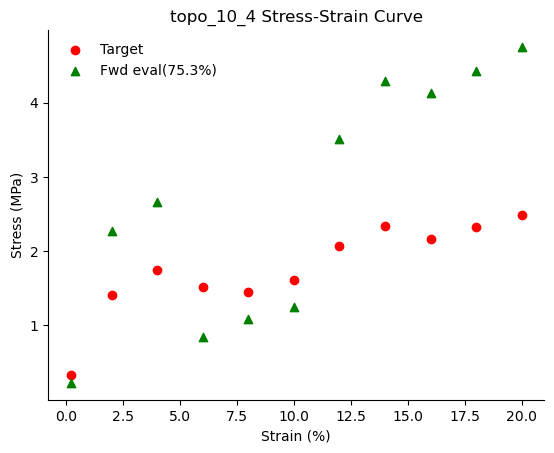

 55%|█████▌    | 11/20 [00:09<00:07,  1.13it/s]

**************************************************
num_components:2
**************************************************
topo_11_0不连通


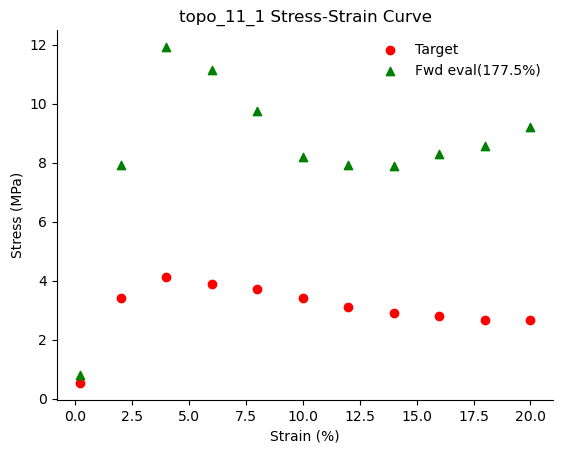

**************************************************
num_components:2
**************************************************
topo_11_2不连通


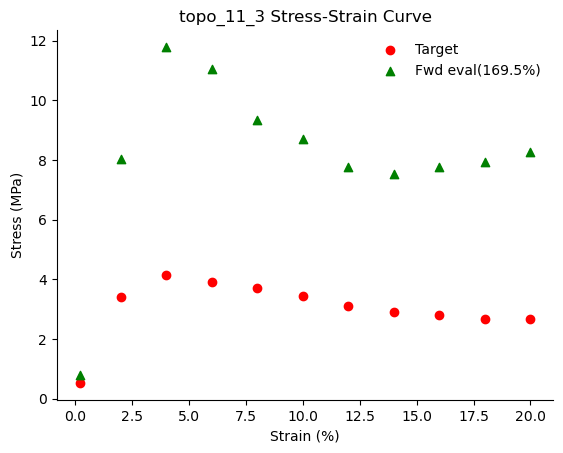

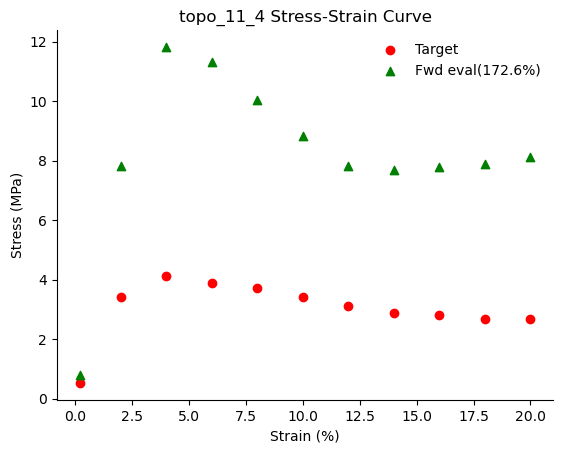

 60%|██████    | 12/20 [00:10<00:06,  1.25it/s]

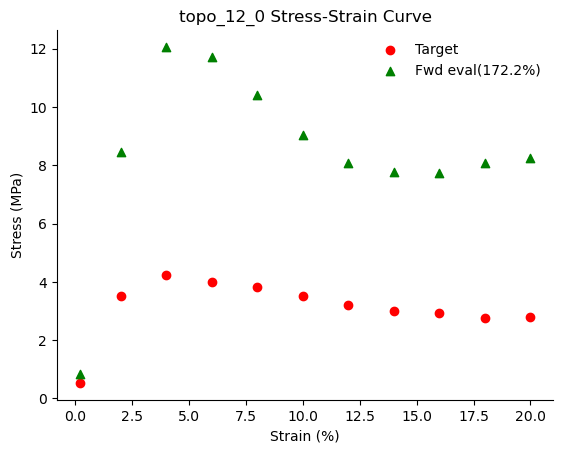

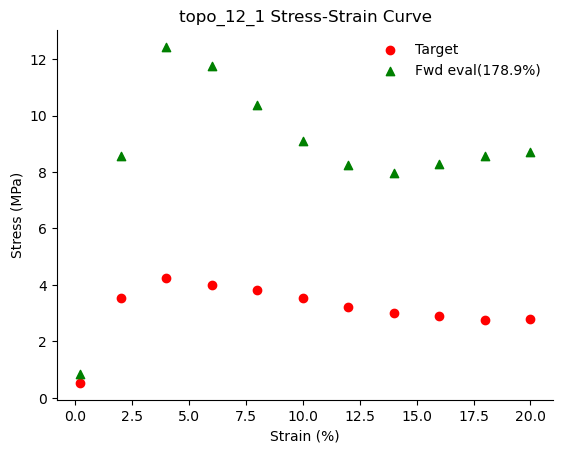

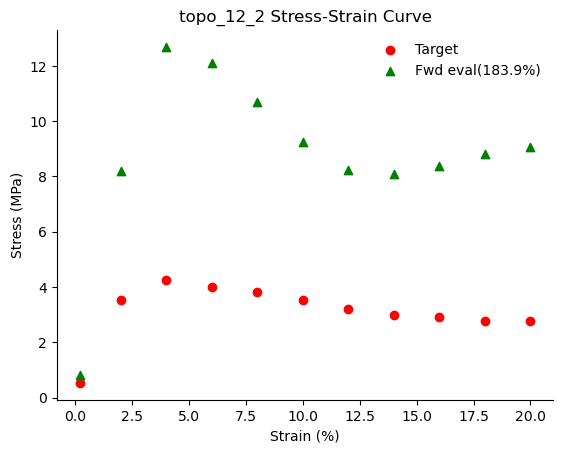

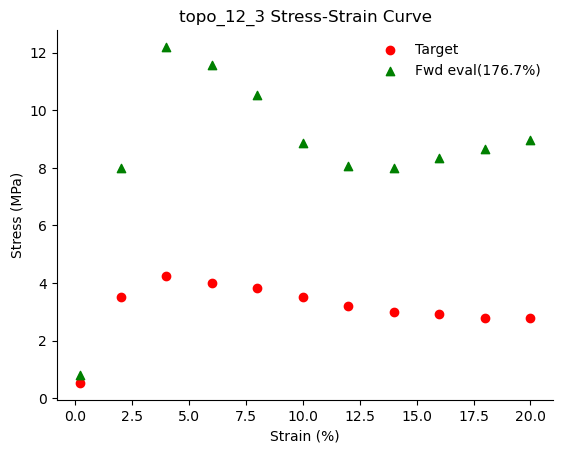

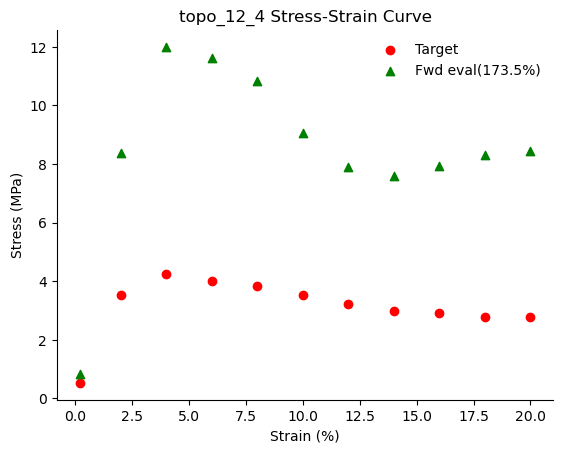

 65%|██████▌   | 13/20 [00:11<00:06,  1.15it/s]

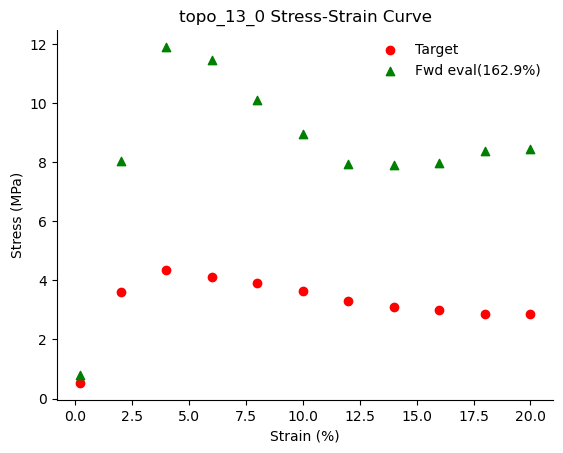

**************************************************
num_components:2
**************************************************
topo_13_1不连通


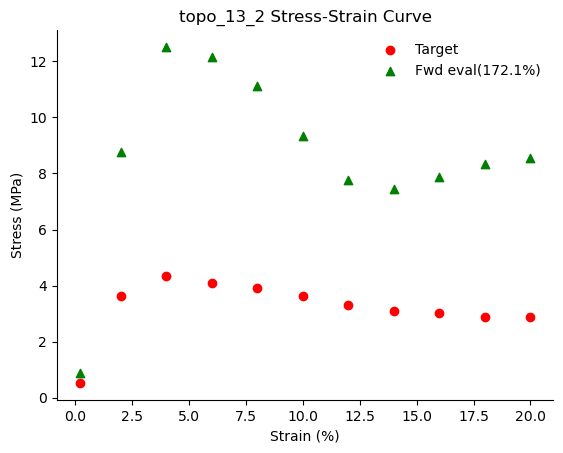

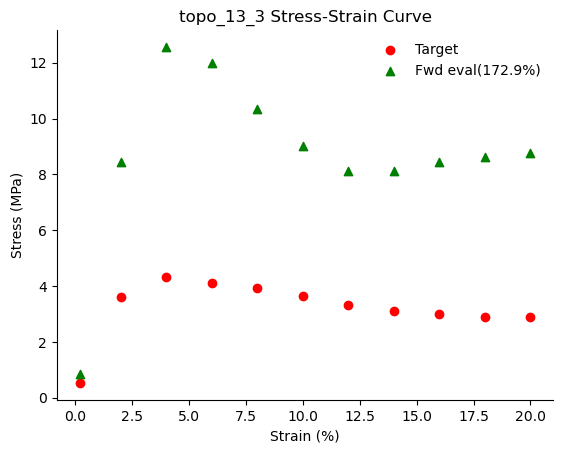

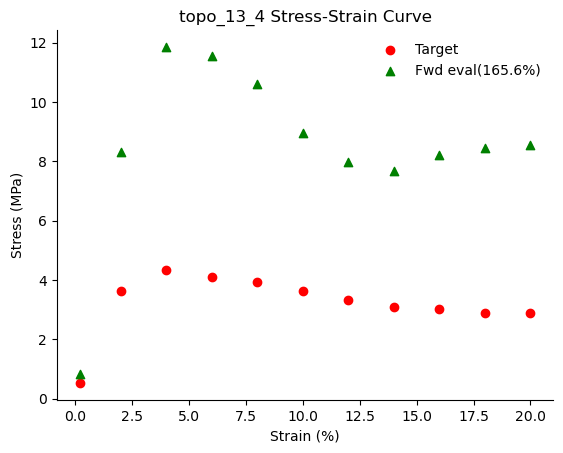

 70%|███████   | 14/20 [00:12<00:05,  1.19it/s]

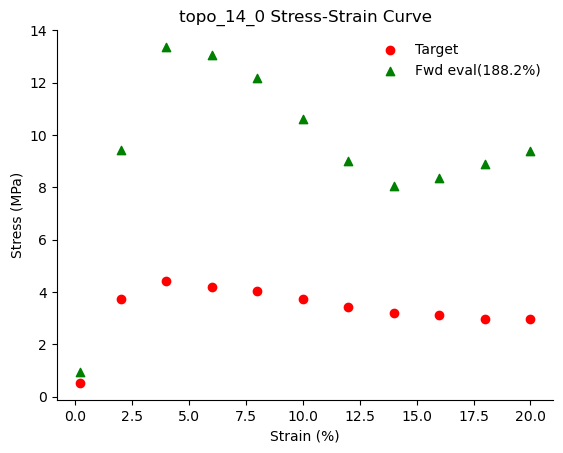

**************************************************
num_components:2
**************************************************
topo_14_1不连通
**************************************************
num_components:2
**************************************************
topo_14_2不连通


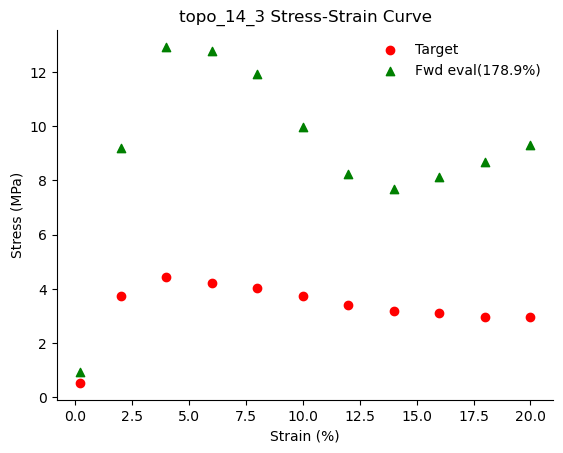

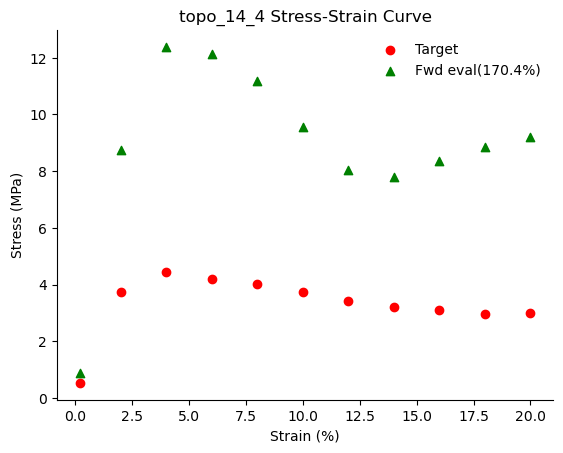

 75%|███████▌  | 15/20 [00:13<00:03,  1.28it/s]

**************************************************
num_components:2
**************************************************
topo_15_0不连通
**************************************************
num_components:2
**************************************************
topo_15_1不连通


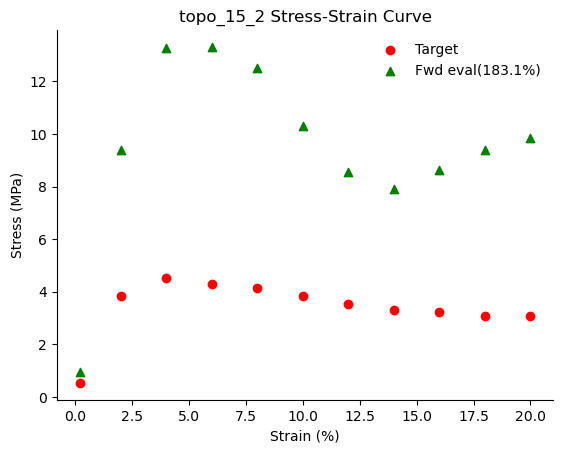

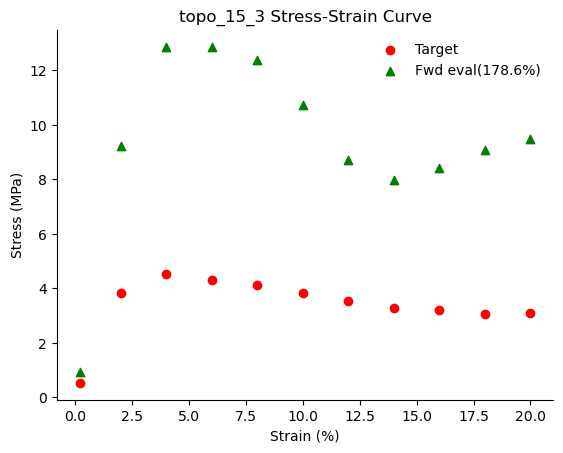

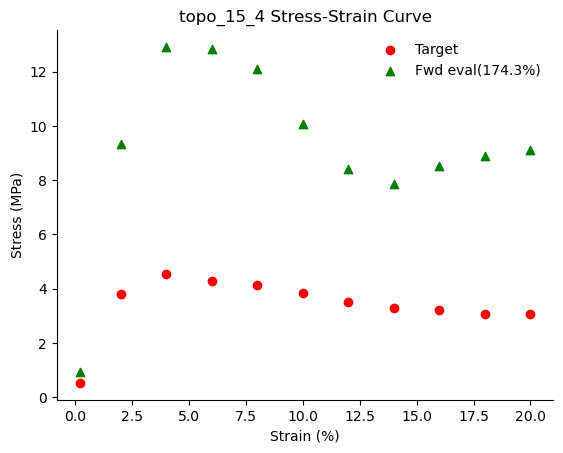

 80%|████████  | 16/20 [00:13<00:02,  1.39it/s]

**************************************************
num_components:2
**************************************************
topo_16_0不连通


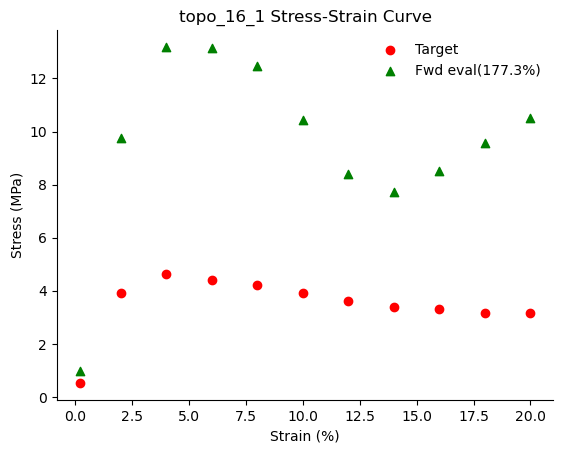

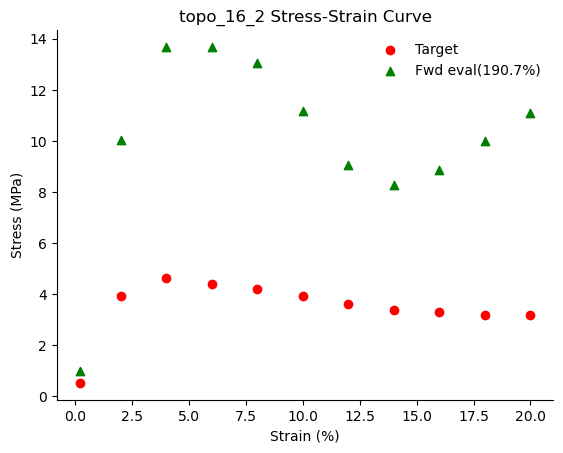

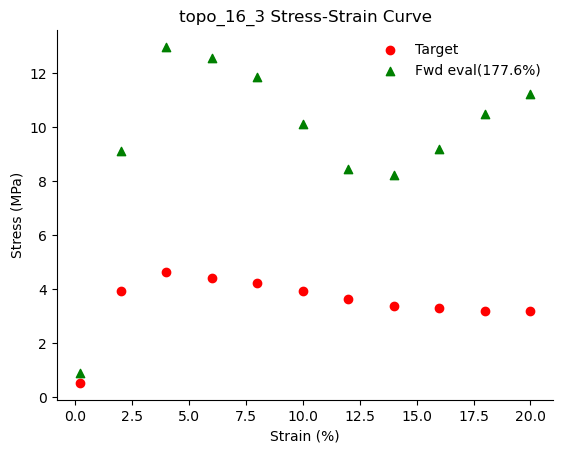

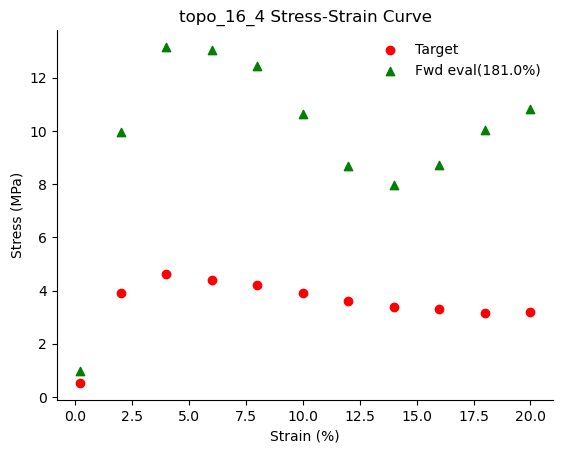

100%|██████████| 20/20 [00:14<00:00,  1.39it/s]

**************************************************
num_components:3
**************************************************
topo_17_0不连通
**************************************************
num_components:4
**************************************************
topo_17_1不连通
**************************************************
num_components:4
**************************************************
topo_17_2不连通
**************************************************
num_components:5
**************************************************
topo_17_3不连通
**************************************************
num_components:2
**************************************************
topo_17_4不连通
**************************************************
num_components:10
**************************************************
topo_18_0不连通
**************************************************
num_components:9
**************************************************
topo_18_1不连通
**************************************************
num_components:13
******

In [56]:
save_connectivity()